In [23]:
path='/Users/kirstytaggart/Lamat/'

In [287]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.axes_size import Fixed, Scaled
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.visualization.wcsaxes import SphericalCircle
import numpy as np
from astropy.io import fits
import os,sys
from astropy.io import ascii
import extinction
from scipy.interpolate import interp1d
from scipy import integrate

# Loads in specific formatting 
pgf_with_latex = { 
    "ytick.right":  True, # 
    "xtick.top":  True, # 
    "xtick.direction":  "in", # direction: {in, out, inout}
    "ytick.direction":  "in", # direction: {in, out, inout}
    "xtick.minor.visible": True,   # visibility of minor ticks on x-axis
    "ytick.minor.visible": True,   # visibility of minor ticks on y-axis
     "xtick.labelsize":15, 
     "ytick.labelsize":15,
     "xtick.major.size": 5,       # major tick size in points
     "ytick.major.size": 5,       # major tick size in points
     "xtick.minor.size": 2.5,     # major tick size in points
     "ytick.minor.size": 2.5,     # major tick size in points
     "xtick.major.width":   0.9,  # major tick width in points
     "ytick.major.width":   0.9,  # major tick width in points
     "figure.dpi":         300, 
     "font.size":         20, 
     "savefig.transparent": False,
#    "axes.labelsize": 30,
    # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],              # LaTeX default is 10pt font.            # Make the legend/label fonts a little smaller
    "pgf.preamble": r"\usepackage[ut f8x]{inputenc} \usepackage[T1]{fontenc}"   

}
mpl.rcParams.update(pgf_with_latex)



In [288]:
# step 1: The photometry in Vega magnitudes can be converted to units of either F_λ or F_ν, and AB magnitudes.
# We will use F_λ and AB mag. Pickles models are in F_λ. 

# For F_ν, using the common AB magnitude system, then a source with a measured magnitude of zero
# in any band by definition has a reference flux of 3631 Jy, ie F0 is always 3631 Jy
#
# m_AB=-2.5*log10(F)+c
# c=0+2.5*log10(3631)
# c = -8.90006562228
#
# For Flux in units of Jy, and magnitude in units of mag
# F_ν(Jy)=10(23-(m_AB+48.6)/2.5)
# m_AB=-2.5*((23-log10(F_ν))-48.6)
#
# m_AB=-2.5*log_10(F_ν)+8.90
# (8.90-m_AB)/2.5=log_10(F_ν)
# F_ν=10^((8.90-m_AB)/2.5)

# for F_λ you can look up the flux of zero magnitude (F0) from:
# http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?mode=browse&gname=HST&asttype=

# F_ν = F_λ*(lambda^2/c) 
# F_λ (erg/cm^2/sec/Angstrom) = F_ν (Jy)/(3.33564*10^(4)*(lambda(A)^2)), where lambda is effective wavelength of filter


In [289]:
# Effect wavelength (A) of each filter from SVO filter service (Filter Profile Service)
# http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?mode=browse&gname=HST&asttype=
# This will be used for the extinction correction, which is wavelength dependent 

# Zeropoints of each filter

eff_wavelength={'WFC3_IR/F110W': 11534.46, 
                'WFC3_IR/F128N':12836.65, 
                'WFC3_IR/F160W':15370.34,
                'WFC3_UVIS1/F218W':2225.17,
                'WFC3_UVIS1/F475W':4773.10,
                'WFC3_UVIS1/F555W':5308.42,
                'WFC3_UVIS1/F625W':6242.56,
                'WFC3_UVIS1/F814W':8039.03,
                'WFPC2-WF/F218W':2203.41,
                'WFPC2-WF/F300W':2984.47,
                'WFPC2-WF/F336W':3344.09,
                'WFPC2-WF/F439W':4311.49,
                'WFPC2-WF/F547M':5483.76,
                'WFPC2-WF/F555W':5442.21,
                'WFPC2-WF/F814W':8001.59,
                'ACS_WFC/F658N':6583.95,
                'ACS_WFC/F814W':8045.53}

# vega mag to fλ in units erg/cm^2/s/A 
zp_fλ={'WFC3_IR/F110W':4.00095e-10,
       'WFC3_IR/F128N':2.48561e-10,
       'WFC3_IR/F160W':1.42481e-10,
       'WFC3_UVIS1/F218W':4.72852e-9,
       'WFC3_UVIS1/F475W':5.26539e-9,
       'WFC3_UVIS1/F555W':3.96448e-9,
       'WFC3_UVIS1/F625W':2.43023e-9,
       'WFC3_UVIS1/F814W':1.13481e-9,
       'WFPC2-WF/F218W':4.81765e-9,
       'WFPC2-WF/F300W':3.61563e-9,
       'WFPC2-WF/F336W':3.32587e-9,
       'WFPC2-WF/F439W':6.77692e-9,
       'WFPC2-WF/F547M':3.60737e-9,
       'WFPC2-WF/F555W':3.68818e-9,
       'WFPC2-WF/F814W':1.14897e-9,
       'ACS_WFC/F658N':1.78447e-9,
       'ACS_WFC/F814W':1.1304e-9}

#fλ in units erg/cm^2/s/A converts to AB magnitude
zp_ab={'WFC3_IR/F110W':8.18187e-10,
       'WFC3_IR/F128N':6.60607e-10,
       'WFC3_IR/F160W':4.60766e-10,
       'WFC3_UVIS1/F218W':2.19848e-8,
       'WFC3_UVIS1/F475W':4.778e-9,
       'WFC3_UVIS1/F555W':3.86293e-9,
       'WFC3_UVIS1/F625W':2.79332e-9,
       'WFC3_UVIS1/F814W':1.68438e-9,
       'WFPC2-WF/F218W':4.81765e-9,
       'WFPC2-WF/F300W':1.22212e-8,
       'WFPC2-WF/F336W':9.73396e-9,
       'WFPC2-WF/F439W':5.85587e-9,
       'WFPC2-WF/F547M':3.61984e-9,
       'WFPC2-WF/F555W':3.67533e-9,
       'WFPC2-WF/F814W':1.70018e-9,
       'ACS_WFC/F658N':2.51115e-9,
       'ACS_WFC/F814W':1.68166e-9}


In [290]:
# step 2  - Apply Galactic extinction correction
#
# Our Milky Way (MW) Galaxy causes "reddening"
# Along the line of sight, dust from the MW absorbs flux
# Dust absorbs preferentially blue light
# Thus, we need to correct any photometry for this effect
#
# A_V = R_V * E(B-V)
#
# E(B-V) is the difference in extinction between the B and V bands
# To get the E(B-V) = A_B-A_V, go to https://ned.ipac.caltech.edu/extinction_calculator
# Look up (Landolt B - Landolt V)
# e.g. E(B-V)=1.348-1.020=0.328
#
# R_V = 3.1$;  changes the shape of the extinction curve, rather than just the amplitude. A_V is linear scaling
# Cardelli, Clayton & Mathis (1989) R_V = 3.1
#
# A_V = R_V * E(B-V) = 3.1 * 0.328 = 1.0168
#
# Then, using this we can use the python extinction package to "deredden" flux by A_V=1.0168
# https://extinction.readthedocs.io/en/latest/

# Examples:
# dereddened_flux=remove(ccm89(wave, 1.0168, 3.1), flux_p)
# extinction.fitzpatrick99(wave, 1.0, 3.1)
# extinction.fm07(values at eff_wavelength, a_v=3.1 * mwebv, unit='aa')
# This returns extinction in magnitudes at each input wavelength.


# this is E(B-V) for 2021sjt, change this with object! 
mwebv=1.348-1.020

# Turn eff_wavelength into an array
eff_wavelength_arr = np.array(list(eff_wavelength.values()))

# Extinction in magnitudes at each input eff_wavelength
extinction_values = extinction.fm07(eff_wavelength_arr, a_v=3.1 *mwebv, unit ='aa') 
#print(extinction_values)

# Extinction in magnitudes at each input eff_wavelength back to dictionary
extinction_values_dic=dict.fromkeys(eff_wavelength)
for i,key in enumerate(extinction_values_dic):
    extinction_values_dic[key]=extinction_values[i]
#print(extinction_values_dic)    



In [291]:
# Dolphot output is in Vega
# put in vega,err
dolphot_vega_mag = {'WFC3_UVIS1/F555W':[26.214,0.128],
               'WFC3_UVIS1/F814W':[24.24,0.078]} 

filters = list(dolphot_vega_mag.keys())
print(dolphot_vega_mag)

def vega_mag_2_fλ_abmag(d,zp_fλ,zp_ab):
    d2=d
    for key in d:
        flux=zp_fλ[key]*np.power(10,(d[key][0])/-2.5)
        flux_unc=flux-zp_fλ[key]*np.power(10,(d[key][0]+d[key][1])/-2.5)
        mag_ab=-2.5*np.log10(flux/zp_ab[key])
        mag_ab_unc=-2.5*np.log10((flux-flux_unc)/zp_ab[key])-mag_ab
        d2[key].append("{:.2f}".format(mag_ab))
        d2[key].append("{:.2f}".format(mag_ab_unc))
        d2[key].append("{:.4e}".format(flux))
        d2[key].append("{:.4e}".format(flux_unc))
    return(d2)


def deredden(d,d_ext_mag):
  d2=d
  flux_values_arr=np.array([float(flux[4]) for flux in d2.values()])
  extinction_values_arr=np.array([d_ext_mag[x] for x in d2.keys()])
  flux_corrected_arr=extinction.remove(extinction_values_arr, flux_values_arr)
  #print(flux_corrected_arr)
  for i,key in enumerate(d2):
    d2[key][0]="{:.3f}".format(d[key][0]-d_ext_mag[key])
    d2[key][2]="{:.3f}".format(float(d[key][2])-d_ext_mag[key])
    d2[key][4]="{:.3e}".format(flux_corrected_arr[i])
  return(d2)
    
#take values of vega and convert to ab anc flux from dict_mag and subtract extinction_values
dolphot_vega_ab_mag_fλ=vega_mag_2_fλ_abmag(dolphot_vega_mag,zp_fλ,zp_ab)
print(dolphot_vega_ab_mag_fλ)

#take values of vega/mag_ab from dict_mag and subtract extinction_values to deredden
dereddened_vega_ab_mag_fλ=deredden(dolphot_vega_ab_mag_fλ,extinction_values_dic)
print(dereddened_vega_ab_mag_fλ)


{'WFC3_UVIS1/F555W': [26.214, 0.128], 'WFC3_UVIS1/F814W': [24.24, 0.078]}
{'WFC3_UVIS1/F555W': [26.214, 0.128, '26.19', '0.13', '1.2959e-19', '1.4412e-20'], 'WFC3_UVIS1/F814W': [24.24, 0.078, '24.67', '0.08', '2.2852e-19', '1.5841e-20']}
{'WFC3_UVIS1/F555W': ['25.140', 0.128, '25.116', '0.13', '3.485e-19', '1.4412e-20'], 'WFC3_UVIS1/F814W': ['23.689', 0.078, '24.119', '0.08', '3.797e-19', '1.5841e-20']}


In [293]:
# Read in the filter profiles into a dictionary 
# col1 is wavelength in A column2 is transmission (values between 0-1)

def createfilterdic(path):
    filter_dic = {}
    dir_list = os.listdir(path)
    #for each file in path
    for file in os.listdir(path):
        data = ascii.read(path+file)
        split=file.split(".")
        filt_name="/"+split[1]
        inst_name=split[0].split("HST_")[1]
        filter_dic.update({inst_name+filt_name: [data]})  
    return filter_dic

filter_dic = createfilterdic(path+'filter_profiles/')
#print(filter_dic)

In [56]:
#https://adsabs.harvard.edu/full/1996BaltA...5..459S first equation (make fnunction of it) scipy.integrate.simpson
#filter_dic['WFC3_UVIS1/F814W']
#filter_dic['WFC3_UVIS1/F555W']
# compare model magnitudes of our own corrected extincted magnitude

[<Table length=3686>
     col1        col2   
   float64     float64  
 ----------- -----------
      4323.0 5.98122e-05
      4324.0 6.57137e-05
      4325.0 7.16168e-05
      4326.0 7.75216e-05
      4327.0  8.3435e-05
      4328.0 8.93434e-05
      4329.0 9.52534e-05
      4330.0 0.000101165
      4331.0 0.000107078
 4331.217773 0.000108368
      4332.0 0.000111374
      4333.0 0.000115208
      4334.0 0.000119043
      4335.0 0.000122879
      4336.0 0.000126716
      4337.0 0.000130554
         ...         ...
      7661.0 6.19294e-05
      7662.0 6.15236e-05
 7662.108398 6.14802e-05
      7663.0  6.1197e-05
      7664.0 6.08795e-05
      7665.0  6.0557e-05
      7666.0 6.02402e-05
      7667.0 5.99183e-05
      7668.0 5.96021e-05
      7669.0 5.92862e-05
      7670.0 5.89653e-05
      7671.0   5.865e-05
      7672.0 5.83349e-05
 7672.111328 5.82993e-05
      7673.0 5.79605e-05
      7674.0 5.75848e-05]

In [264]:
# Fit the pickles library! 
# Load all pickles files as a Dictionary
# https://archive.stsci.edu/hlsps/reference-atlases/cdbs/grid/pickles/AA_README
# https://ui.adsabs.harvard.edu/abs/1998PASP..110..863P/abstract

def createpickledic(path):
    pickle_dic = {}
    dir_list = os.listdir(path)
    #for each file in pickles folder
    for file in os.listdir(path):
        img = fits.open(path+file)
        data, header = fits.getdata(path+file, header = True)
        pickle_dic.update({file: [data , header]})  
    return pickle_dic

pickle_dic = createpickledic(path+'dat_uvk/')

In [266]:
for i,key in enumerate(pickle_dic):
    print(pickle_dic[key][0])

[( 1150., 0.0000000e+00) ( 1155., 0.0000000e+00) ( 1160., 0.0000000e+00)
 ... (24990., 5.6138302e-11) (24995., 4.9043939e-11)
 (25000., 7.0032708e-12)]
[( 1150., 4.4931454e-12) ( 1155., 4.2605214e-11) ( 1160., 9.8624921e-11)
 ... (24990., 2.7592524e-11) (24995., 2.4116204e-11)
 (25000., 3.4439543e-12)]
[( 1150., 0.) ( 1155., 0.) ( 1160., 0.) ... (24990., 0.) (24995., 0.)
 (25000., 0.)]
[( 1150., 5.6945023e-08) ( 1155., 5.9996950e-08) ( 1160., 4.9119841e-08)
 ... (24990., 1.1940607e-11) (24995., 1.0434386e-11)
 (25000., 1.4900633e-12)]
[( 1150., 0.0000000e+00) ( 1155., 0.0000000e+00) ( 1160., 0.0000000e+00)
 ... (24990., 2.9663022e-08) (24995., 2.5946211e-08)
 (25000., 3.7057732e-09)]
[( 1150., 0.0000000e+00) ( 1155., 0.0000000e+00) ( 1160., 0.0000000e+00)
 ... (24990., 3.4732411e-11) (24995., 3.0358157e-11)
 (25000., 4.3353845e-12)]
[( 1150., 0.0000000e+00) ( 1155., 0.0000000e+00) ( 1160., 0.0000000e+00)
 ... (24990., 2.7048569e-10) (24995., 2.3643604e-10)
 (25000., 3.3765234e-11)]
[( 

In [326]:
wav_pickle=np.arange(1150., 25005., 5)

dup_dictionary=(dict.fromkeys(filter_dic))


for j,key2 in enumerate(pickle_dic):
        flux=pickle_dic[key2][0]['FLUX']
        #print(np.shape(wav_pickle[ind]),np.shape(flux[ind]),np.shape(wav_pickle[ind]))
        #Fλ_spec=integrate.simpson(wav_pickle[ind]*flux[ind]*(int_filt(wave[ind])),wav_pickle[ind])/ integrate.simpson(wav_pickle[ind]*int_filt(wav_pickle[ind]),wav_pickle[ind])
        for i,key in enumerate(filter_dic):
         # interpolate over filter
         int_filt=interp1d(filter_dic[key][0]['col1'],filter_dic[key][0]['col2'])
         # find pickle wavelengths in the filters
         ind=(wav_pickle>min(filter_dic[key][0]['col1'])) & (wav_pickle<max(filter_dic[key][0]['col1']))
         #print(wav_pickle[ind])
         #print(np.shape(wav_pickle[ind]),np.shape(flux[ind]),np.shape(int_filt(wav_pickle[ind])))
         integral=integrate.simpson(wav_pickle[ind]*flux[ind]*(int_filt(wav_pickle[ind])),wav_pickle[ind])/ integrate.simpson(wav_pickle[ind]*int_filt(wav_pickle[ind]),wav_pickle[ind])
         print(integral)   
        sys.exit()
        

#Fλ_spec_g =  integrate.simpson(wave[ind_g]*flux[ind_g]*(int_filt_g(wave[ind_g])),wave[ind_g])/ integrate.simpson(wave[ind_g]*int_filt_g(wave[ind_g]),wave[ind_g])


{'WFPC2-WF/F336W': None, 'WFPC2-WF/F300W': None, 'WFPC2-WF/F814W': None, 'WFPC2-WF/F439W': None, 'ACS_WFC/F814W': None, 'WFC3_UVIS1/F555W': None, 'WFPC2-WF/F218W': None, 'WFPC2-WF/F555W': None, 'WFC3_UVIS1/F218W': None, 'WFC3_IR/F110W': None, 'WFC3_UVIS1/F625W': None, 'WFC3_IR/F128N': None, 'WFC3_UVIS1/F475W': None, 'ACS_WFC/F658N': None, 'WFC3_UVIS1/F814W': None, 'WFPC2-WF/F547M': None, 'WFC3_IR/F160W': None}
1.7159038071384961e-09
1.1076195522784996e-09
2.122427009648192e-09
3.7030916888324815e-09
2.100118088923668e-09
3.667322011254225e-09
1.1147662631840487e-10
3.597481762441528e-09
1.0883405766893142e-10
9.506600304834104e-10
3.1387469485496964e-09
7.013370993349047e-10
3.809602403281867e-09
2.850271265145133e-09
2.1032683309326988e-09
3.6250188687915397e-09
4.685429093126564e-10


SystemExit: 

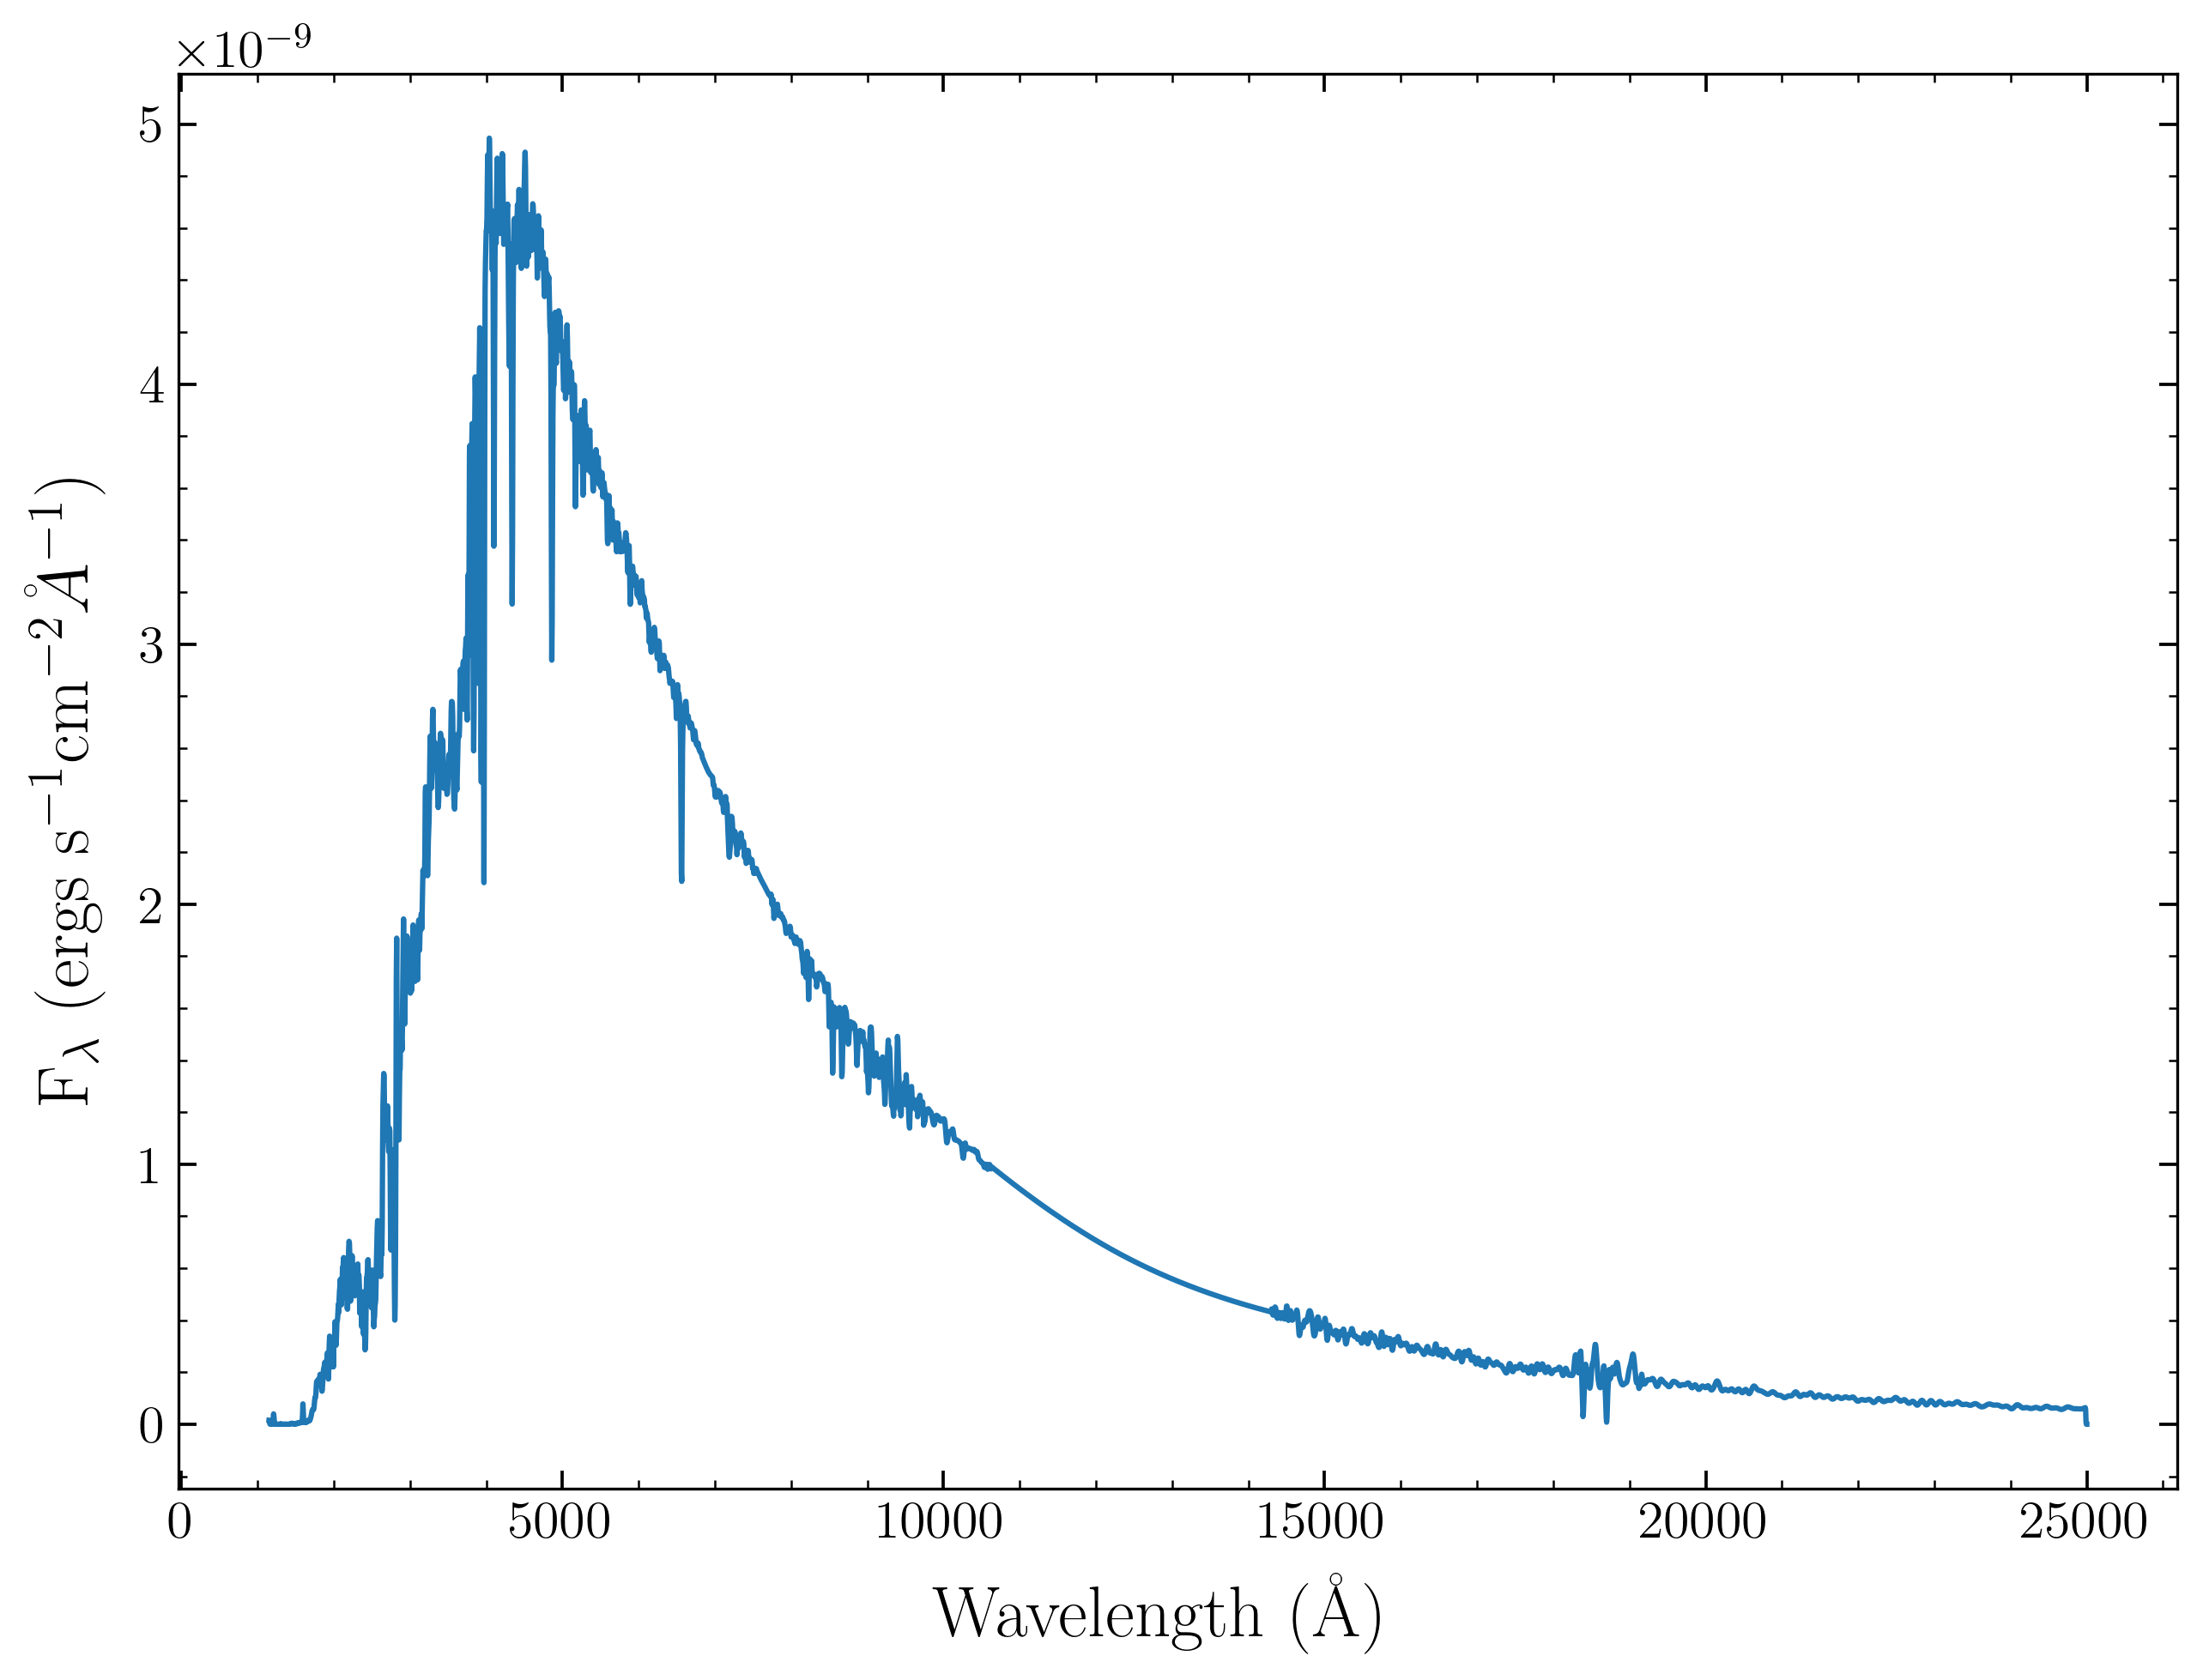

In [41]:
#Example plot of 51st star model from Pickles library

fig = plt.figure(constrained_layout=True,figsize=(8,6),facecolor='white')
gs = GridSpec(1, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])

# example data
#x = np.arange(0.1, 4, 0.5)
#y = np.exp(-x)
#error = 0.1 + 0.2 * x
#lower_error = 0.4 * error
#upper_error = error

ax1.plot(pickle_dic['pickles_uk_51.fits'][0]['WAVELENGTH'],pickle_dic['pickles_uk_51.fits'][0]['FLUX'])

asymmetric_error = [lower_error, upper_error]

fig.text(0.5, -0.05, r'Wavelength (\AA)', ha='center')
fig.text(-0.05, 0.5, r'F$_\lambda$ (ergs s$^{-1}$cm$^{-2}\AA^{-1}$)', va='center', rotation='vertical')

plt.savefig('pickles_uk_51_SED_plot.png',bbox_inches='tight')

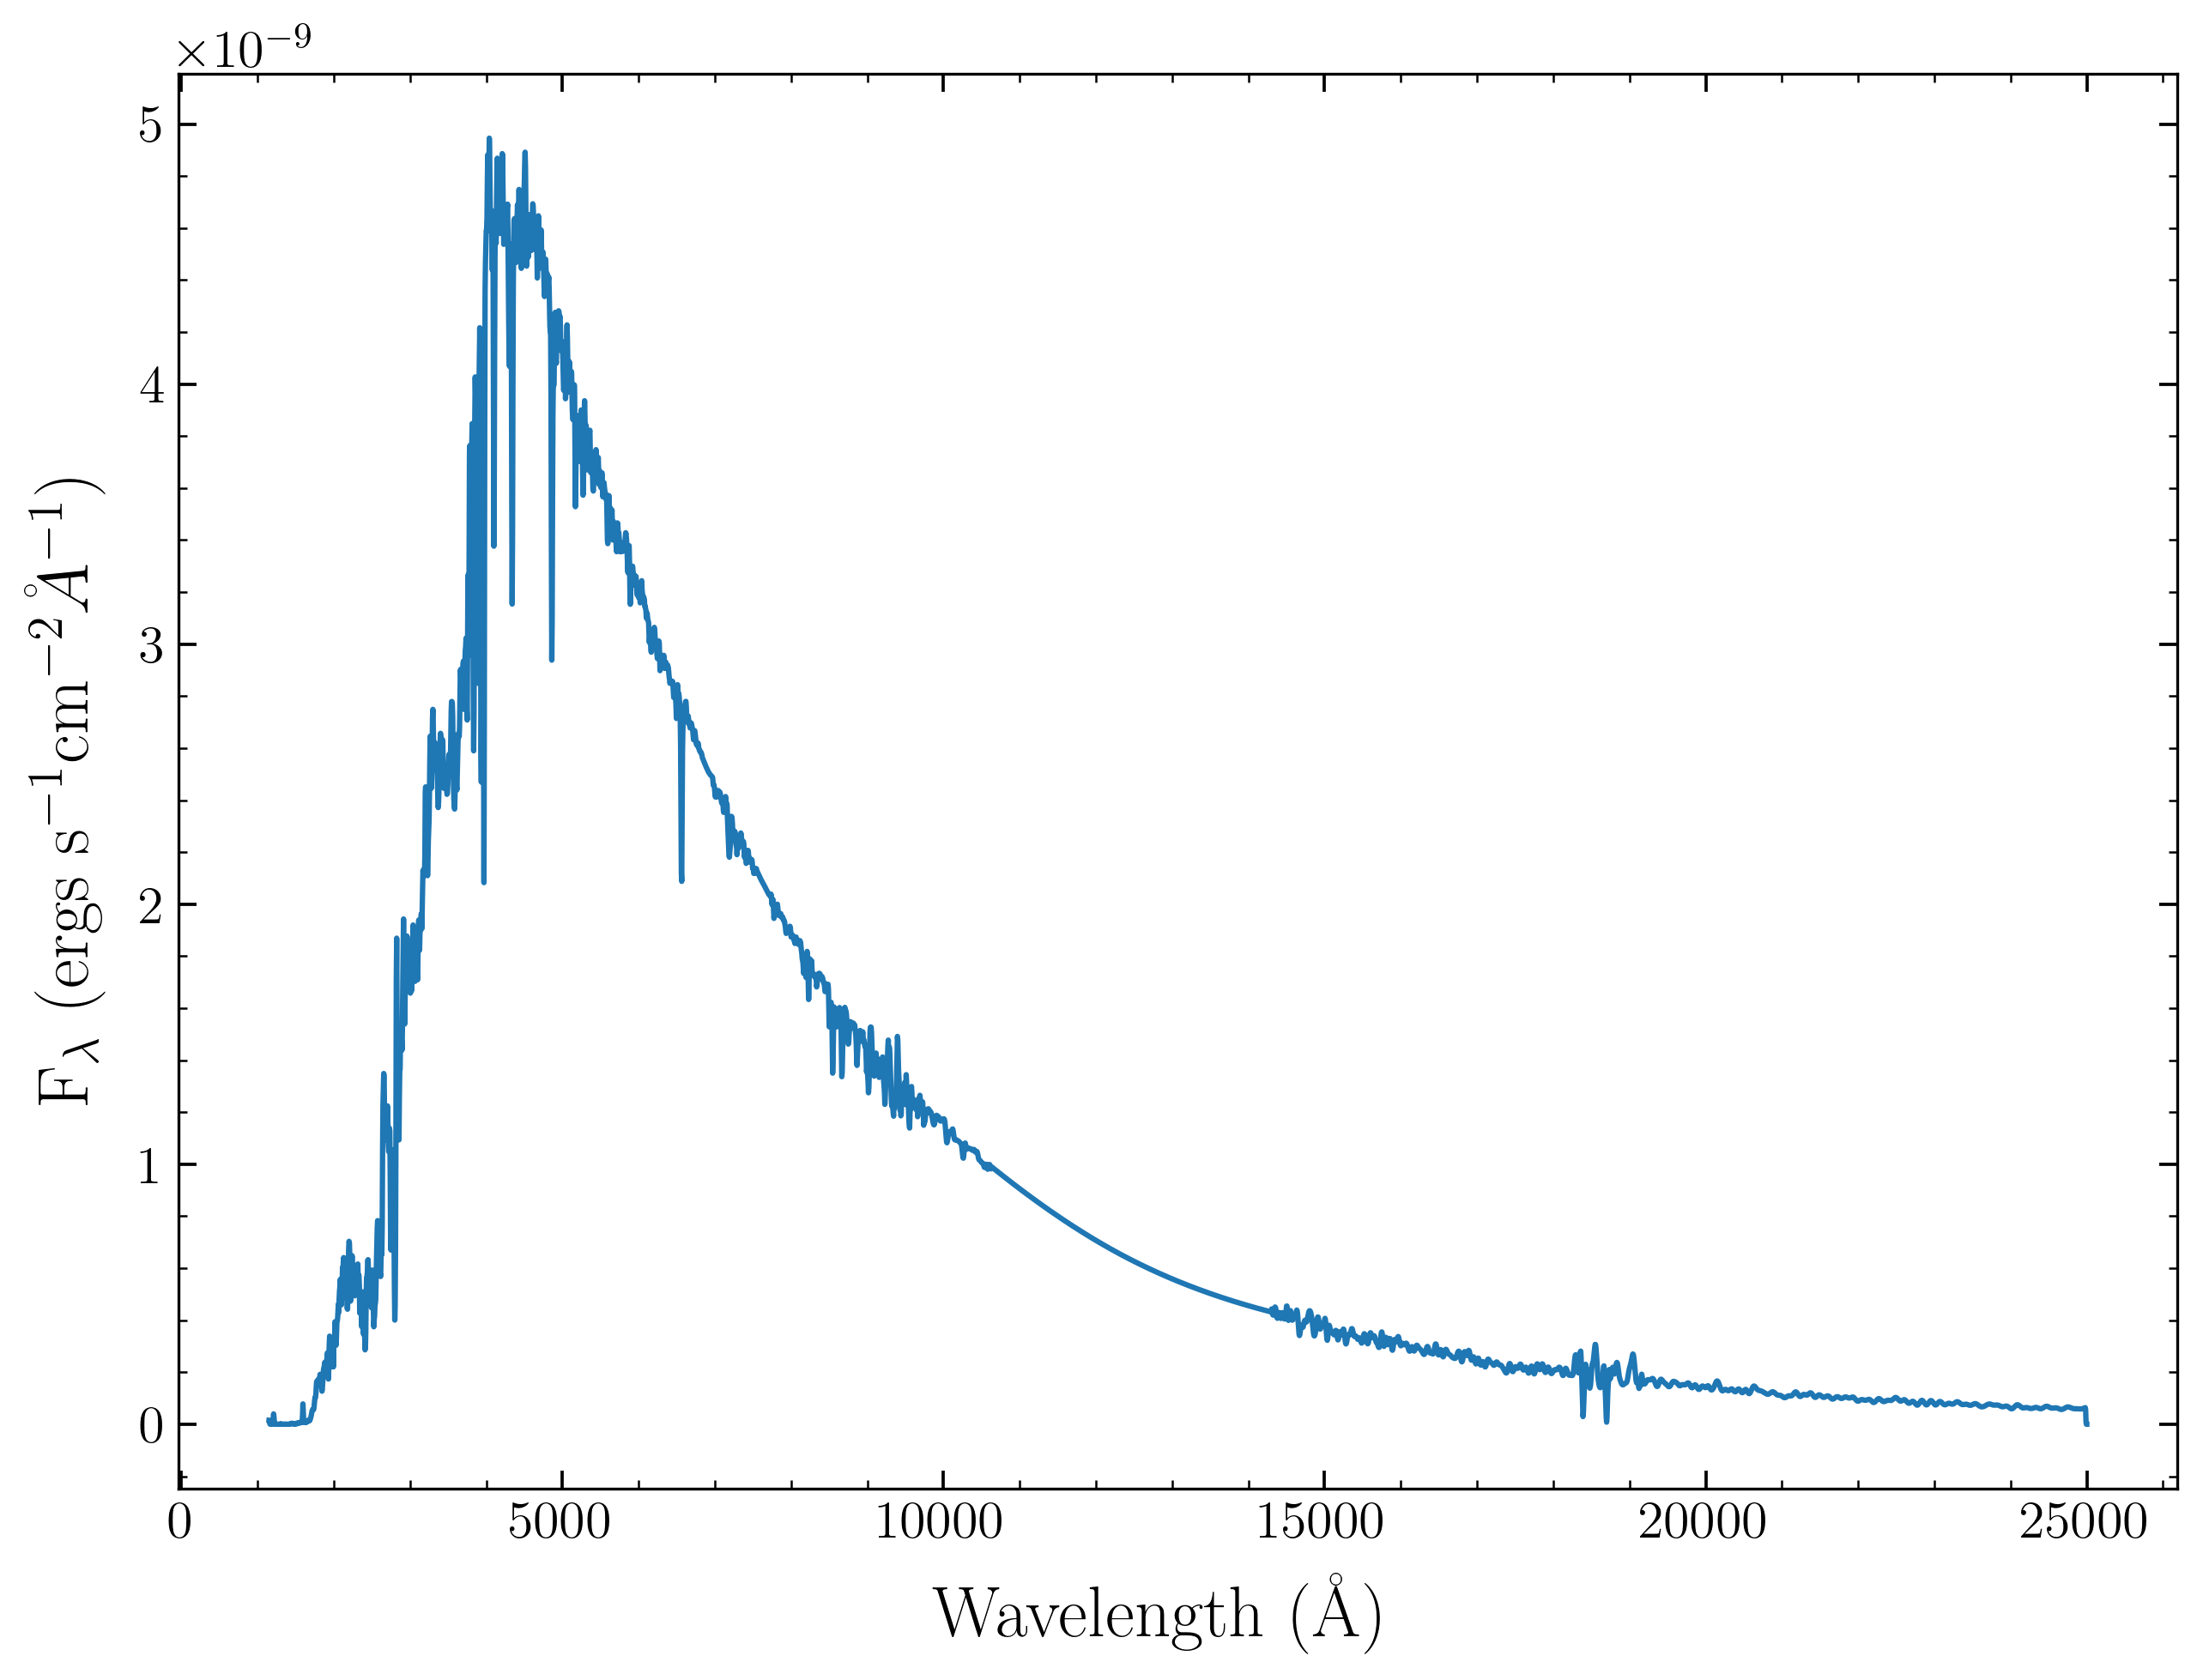

In [40]:
#Example plot of 51st star model from Pickles library with synthethetic photometry

fig = plt.figure(constrained_layout=True,figsize=(8,6),facecolor='white')
gs = GridSpec(1, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])

# example data
#x = np.arange(0.1, 4, 0.5)
#y = np.exp(-x)
#error = 0.1 + 0.2 * x
#lower_error = 0.4 * error
#upper_error = error

ax1.plot(pickle_dic['pickles_uk_51.fits'][0]['WAVELENGTH'],pickle_dic['pickles_uk_51.fits'][0]['FLUX'])

asymmetric_error = [lower_error, upper_error]

#ax1.errorbar(x, y*1e-9, yerr=asymmetric_error, fmt='o')

fig.text(0.5, -0.05, r'Wavelength (\AA)', ha='center')
fig.text(-0.05, 0.5, r'F$_\lambda$ (ergs s$^{-1}$cm$^{-2}\AA^{-1}$)', va='center', rotation='vertical')

plt.savefig('pickles_uk_51_SED_plot_synt_photometry.png',bbox_inches='tight')

In [ ]:
# But a more detailed way to do it is by using a filter transmission profile.
# This way, you do :
#
# avg_flux = int F_spec_lambda * filter_transmission d_lambda / int filter_transmission d_lambda
#

int_filt_g = interp1d(g_PS1[:,0],g_PS1[:,1])
int_filt_r = interp1d(r_PS1[:,0],r_PS1[:,1])
int_filt_i = interp1d(i_PS1[:,0],i_PS1[:,1])
int_filt_z = interp1d(z_PS1[:,0],z_PS1[:,1])
int_filt_z = interp1d(z_PS1[:,0],z_PS1[:,1])
int_filt_f475w = interp1d(f475w_hst[:,0],f475w_hst[:,1])

ind_g=(wave>min(g_PS1[:,0])) & (wave<max(g_PS1[:,0]))
ind_r=(wave>min(r_PS1[:,0])) & (wave<max(r_PS1[:,0]))
ind_i=(wave>min(i_PS1[:,0])) & (wave<max(i_PS1[:,0]))
ind_z=(wave>min(z_PS1[:,0])) & (wave<max(z_PS1[:,0]))
ind_f475w=(wave>min(f475w_hst[:,0])) & (wave<max(f475w_hst[:,0]))

Fλ_spec_g =  integrate.simpson(wave[ind_g]*flux[ind_g]*(int_filt_g(wave[ind_g])),wave[ind_g])/ integrate.simpson(wave[ind_g]*int_filt_g(wave[ind_g]),wave[ind_g])
Fλ_spec_r =  integrate.simpson(wave[ind_r]*flux[ind_r]*(int_filt_r(wave[ind_r])),wave[ind_r])/ integrate.simpson(wave[ind_r]*int_filt_r(wave[ind_r]),wave[ind_r])
Fλ_spec_i =  integrate.simpson(wave[ind_i]*flux[ind_i]*(int_filt_i(wave[ind_i])),wave[ind_i])/ integrate.simpson(wave[ind_i]*int_filt_i(wave[ind_i]),wave[ind_i])
Fλ_spec_z =  integrate.simpson(wave[ind_z]*flux[ind_z]*(int_filt_z(wave[ind_z])),wave[ind_z])/ integrate.simpson(wave[ind_z]*int_filt_z(wave[ind_z]),wave[ind_z])
Fλ_spec_f475w =  integrate.simpson(wave[ind_f475w]*flux[ind_f475w]*(int_filt_f475w(wave[ind_f475w])),wave[ind_f475w])/ integrate.simpson(wave[ind_f475w]*int_filt_f475w(wave[ind_f475w]),wave[ind_f475w])


array([ 1150.,  1155.,  1160., ..., 24990., 24995., 25000.], dtype=float32)

array([ 1150.,  1155.,  1160., ..., 24990., 24995., 25000.], dtype=float32)

In [283]:
pickle_dic['pickles_uk_1.fits'][0]['WAVELENGTH']

array([ 1150.,  1155.,  1160., ..., 24990., 24995., 25000.], dtype=float32)

In [296]:
np.linspace(start=1150, stop=25000, num=5)

array([ 1150. ,  7112.5, 13075. , 19037.5, 25000. ])

In [298]:
np.arange(1150., 25005., 5)


array([ 1150.,  1155.,  1160., ..., 24990., 24995., 25000.])